In [1]:
import os
import sys
from pathlib import Path
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
from skimage.measure import regionprops_table

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

In [4]:
# Define image and masks folder
info_csv = data_meta / "all_info.csv"

df = pd.read_csv(info_csv)

In [5]:
df.Location = df.Location.astype(str)

# Get nuclei, cyto, cell level features

In [6]:
def get_condition(df, condition):
    imgs_path = []
    markers = []

    df = df[(df.Location == condition) & (df.Z_stack == "Combined")]
    for row in df.itertuples():
        if row.Marker in ["Hoeschst", "Phalloidin", "WGA", 'Concanavalin A']:
            continue
        imgs_path.append(row.Path_corrected)
        markers.append(row.Marker)
    return imgs_path, markers

def get_masks(mask_folder):
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tiff" in name:
                condition = name.split("_")[0]
                masks[condition] = masks.get(condition, {})
                filename = os.path.join(dirpath, name)
                if "cyto" in name:
                    img = skimage.io.imread(filename)
                    masks[condition]["cyto"] = img
                elif "nuclei" in name:
                    img = skimage.io.imread(filename)
                    masks[condition]["nuclei"] = img
    return masks

def qc_nuclei(mask_cyto, mask_nuclei):
    '''
    Function to check if cell masks contain nuclei
    '''
    cell = np.zeros((mask_cyto.shape), dtype=np.uint8)
    nuclei = np.zeros((mask_cyto.shape), dtype=np.uint8)
    cyto = np.zeros((mask_cyto.shape), dtype=np.uint8)

    for label in range(1, mask_cyto.max()):
        # Check if cell has nuclei
        cell_mask = np.where(mask_cyto == label, 1, 0).astype(np.uint8)
        maski = cv2.bitwise_and(mask_nuclei, mask_nuclei, mask=cell_mask)

        # If no nuclei detected then pass
        if maski.max() == 0:
            continue

        # Link label accross cell, nuclei, cyto
        cell = np.where(mask_cyto == label, label, cell)
        nuclei = np.where(maski > 0, label, nuclei)
        maski = cv2.subtract(cell_mask, maski)
        cyto = np.where(maski > 0, label, cyto)
    return cell, nuclei, cyto

def get_region_props(img, cell, nuclei, cyto, marker, condition, prop):
    '''
    Get regionprops from masked region
    '''
    cell_props = regionprops_table(cell, img, properties=prop)
    nuclei_props = regionprops_table(nuclei, img, properties=prop)
    cyto_props = regionprops_table(cyto, img, properties=prop)

    props = [cell_props, nuclei_props, cyto_props]
    prefix = ["Cell_", "Nuclei_", "Cyto_"]
    df_marker = pd.concat(
        [
            pd.DataFrame(prop).add_prefix(prefix[idx])
            for idx, prop in enumerate(props)
        ],
        axis=1,
    )
    df_marker["Marker"] = marker
    df_marker["Location"] = condition
    df_marker["Id"] = regionprops_table(cell, properties=['label'])['label']
    
    return df_marker

def measure_prop(df, masks, show=False, save=False):
    appended_data_intensity = []
    appended_data_morphology = []

    # Get each segmented cell region with corresponding nuclei and cell
    for idx, condition in enumerate(masks.keys()):
        mask_cyto = masks[condition]["cyto"]
        mask_nuclei = masks[condition]["nuclei"]

        cell, nuclei, cyto = qc_nuclei(mask_cyto, mask_nuclei)
        
        imgs, markers = get_condition(df, condition)
        for idx, img_path in enumerate(imgs):
            img = skimage.io.imread(img_path)
            df_marker = get_region_props(img, cell, nuclei, cyto, markers[idx], condition, ['mean_intensity'])
            appended_data_intensity.append(df_marker)
            
            # Get morphology only one time because morphology accross cell are the same
            if idx == 0:
                df_marker = get_region_props(img, cell, nuclei, cyto, markers[idx], condition, ['area'])
                appended_data_morphology.append(df_marker)

                if show:
                    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                    ax[0].imshow(cell)
                    ax[1].imshow(nuclei)
                    ax[2].imshow(cyto)
                    plt.show()

    df_prop_intensity = pd.concat(appended_data_intensity, ignore_index=True)
    df_prop_intensity = df_prop_intensity.sort_values(
        by=["Location", "Id"]
    ).reset_index(drop=True)

    df_prop_morph = pd.concat(appended_data_morphology, ignore_index=True)
    df_prop_morph = df_prop_morph.sort_values(by=["Location", "Id"]).reset_index(
        drop=True
    )

    if save:
        df_prop_intensity.to_csv(data_meta / "measurements_intensity.csv", index=False)
        df_prop_morph.to_csv(data_meta / "measurements_morphology.csv", index=False)

    return df_prop_intensity, df_prop_morph

In [7]:
masks = get_masks(data_mask)

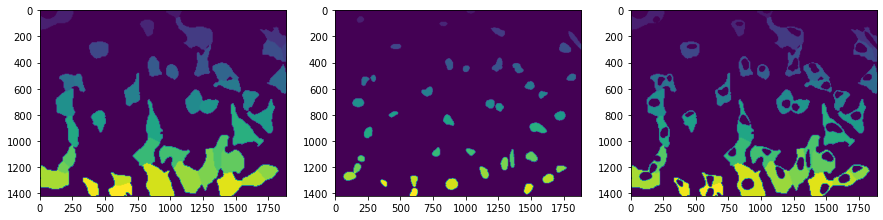

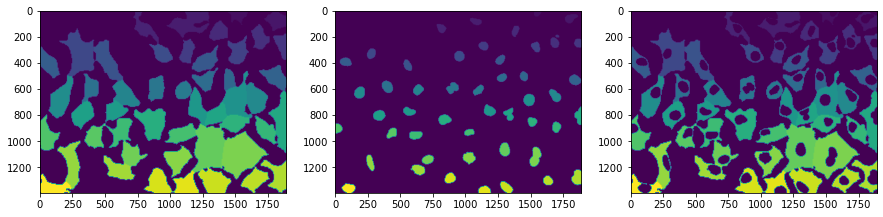

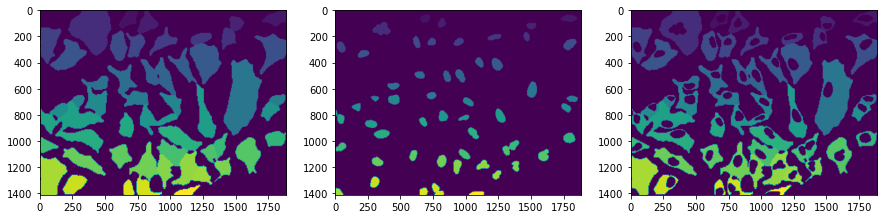

In [8]:
df_prop_i, df_prop_m = measure_prop(df, masks, save=True, show=True)

In [9]:
df_prop_i

,Cell_mean_intensity,Nuclei_mean_intensity,Cyto_mean_intensity,Marker,Location,Id
0,689.296122,1382.594822,403.867185,Cyclin E,1,3
1,975.776122,1391.053184,804.807836,EMMPRIN,1,3
2,212.311224,252.052484,195.949870,Wnt1,1,3
3,1126.670816,2207.494752,681.698934,Non-phospho-B-catenin,1,3
4,550.292857,685.699090,494.546528,APC,1,3
...,...,...,...,...,...,...
2140,123.265828,183.971641,87.647879,phospho-B-catenin,3,61
2141,85.746494,86.315491,85.412646,RNF 43,3,61
2142,169.124918,379.952145,45.426165,AKT,3,61
2143,92.849390,128.889401,71.703619,p-mTOR,3,61


In [10]:
df_prop_m

,Cell_area,Nuclei_area,Cyto_area,Marker,Location,Id
0,4900,1429,3471,Cyclin E,1,3
1,20881,2098,18783,Cyclin E,1,4
2,9486,1610,7876,Cyclin E,1,5
3,15647,4176,11471,Cyclin E,1,7
4,34947,4412,30535,Cyclin E,1,8
...,...,...,...,...,...,...
138,45214,2552,42662,Cyclin E,3,53
139,18343,4633,13710,Cyclin E,3,56
140,14222,4946,9276,Cyclin E,3,57
141,7797,3043,4754,Cyclin E,3,58


# Get pixel level features

In [11]:
def get_condition(df, condition):
    imgs_path = []
    markers = []

    df = df[(df.Location == condition) & (df.Z_stack == "Combined")]
    for row in df.itertuples():
        imgs_path.append(row.Path_corrected)
        markers.append(row.Marker)
    return imgs_path, markers

def combined_imgs(imgs: List[str]) -> np.ndarray:
    '''
    Return an multiplex image of dimension (num markers, height,width)
    '''
    if not imgs:
        raise Exception("You passed a empty list of images path")
    pixels = [skimage.io.imread(img) for img in imgs]
    return np.stack(pixels)

def get_multiplex_pix(df, masks, save=False):
    df_appended = []
    for idx, condition in enumerate(masks.keys()):
        imgs, markers = get_condition(df, condition)
        pixels = combined_imgs(imgs)

        mask_cyto = masks[condition]["cyto"]
        mask_nuclei = masks[condition]["nuclei"]
        cell, _, _ = qc_nuclei(mask_cyto, mask_nuclei)
        labels = [n for n in np.unique(cell) if n > 0]
    
        # Extracted all multiplex pixels in cell
        rows, cols = np.where(np.isin(cell, labels))
        cell_pixels = pixels[:, rows, cols]
                
        # Create dataframe
        df_pixels = pd.DataFrame(cell_pixels.T, columns=markers)
        df_pixels['Location'] = condition
        df_pixels['X'] = rows
        df_pixels['Y'] = cols
        df_pixels['Id'] = cell[rows,cols]
        df_dapi = df_pixels.filter(like='Hoeschst')
        df_pixels = df_pixels.drop(df_dapi, axis=1)
        df_pixels.insert(0, column='Hoeschst', value=df_dapi.mean(axis=1).astype(np.uint16))
        df_appended.append(df_pixels)
        
    df_pixels = pd.concat(df_appended, ignore_index=True)
    
    if save:
        df_pixels.to_csv(data_meta / "pixel_intensity.csv", index=False)
    
    return df_pixels

In [12]:
masks = get_masks(data_mask)

In [13]:
df_pixels = get_multiplex_pix(df, masks, save=True)

In [14]:
df_pixels.describe()

,Hoeschst,Phalloidin,WGA,Cyclin E,EMMPRIN,Wnt1,Non-phospho-B-catenin,APC,DKK1,DKK2,...,p-AKT,phospho-B-catenin,RNF 43,AKT,p-mTOR,mTOR,Concanavalin A,X,Y,Id
count,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,...,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06,3.083855e+06
mean,3.427300e+03,6.242738e+03,1.048080e+04,5.385115e+02,5.420286e+02,1.778234e+02,7.022064e+02,5.517815e+02,1.322412e+02,5.598181e+02,...,5.451829e+02,2.937764e+02,1.086155e+02,5.254168e+02,2.981595e+02,1.176015e+02,8.286505e+03,7.671437e+02,9.817562e+02,2.827511e+01
std,6.219117e+03,4.199292e+03,6.935838e+03,5.939626e+02,6.614535e+02,1.830030e+02,6.426538e+02,6.266901e+02,6.388679e+01,5.072985e+02,...,4.450124e+02,1.993124e+02,5.791353e+01,3.823508e+02,2.218764e+02,6.078431e+01,3.492038e+03,3.937641e+02,5.386222e+02,1.425449e+01
min,3.500000e+01,7.550000e+02,2.241000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.321000e+03,0.000000e+00,0.000000e+00,2.000000e+00
25%,1.050000e+02,3.586000e+03,5.501000e+03,1.830000e+02,2.040000e+02,7.900000e+01,2.580000e+02,2.430000e+02,8.800000e+01,2.100000e+02,...,2.120000e+02,1.650000e+02,6.800000e+01,2.480000e+02,1.740000e+02,7.700000e+01,5.951000e+03,4.310000e+02,4.990000e+02,1.600000e+01
50%,1.460000e+02,5.076000e+03,7.566000e+03,4.170000e+02,4.140000e+02,1.390000e+02,5.270000e+02,4.400000e+02,1.280000e+02,4.230000e+02,...,4.600000e+02,2.800000e+02,1.050000e+02,4.790000e+02,2.800000e+02,1.140000e+02,7.236000e+03,7.960000e+02,1.034000e+03,2.900000e+01
75%,2.782000e+03,7.549000e+03,1.384200e+04,7.470000e+02,6.930000e+02,2.200000e+02,9.840000e+02,7.020000e+02,1.700000e+02,7.600000e+02,...,7.840000e+02,4.020000e+02,1.460000e+02,7.440000e+02,3.950000e+02,1.530000e+02,9.533000e+03,1.115000e+03,1.441000e+03,4.000000e+01
max,4.015200e+04,6.553500e+04,6.553500e+04,4.532100e+04,6.311900e+04,2.499800e+04,1.522400e+04,6.285000e+04,3.231000e+03,1.158200e+04,...,2.357600e+04,2.579600e+04,3.244000e+03,2.872500e+04,6.260300e+04,4.310000e+03,6.200600e+04,1.420000e+03,1.888000e+03,6.100000e+01
